# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession


from pyspark.sql.functions import sum as Fsum

from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor, desc
from pyspark.sql.types import IntegerType, DateType, StringType
from pyspark.sql.window import Window
from pyspark.sql import functions as sF
from pyspark.sql import types as sT

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml.feature import StandardScaler 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import pyspark.sql.functions as fn
from sklearn import preprocessing
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
# create a Spark session
#查看数据集的列及其变量的含义

spark = SparkSession.builder.appName("Sparkify").getOrCreate()
df = spark.read.json('mini_sparkify_event_data.json')

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)




 |-- artist: string (歌手)
 |-- auth: string (登录状态)
 |-- firstName: string (名字)
 |-- gender: string (性别)
 |-- itemInSession: long (连续变量, 具体含义暂不明确)
 |-- lastName: string (姓氏)
 |-- length: double (听歌时长)
 |-- level: string (会员等级)
 |-- location: string (地区)
 |-- method: string (分类变量, 具体含义暂不明确, 可能与用户发送\接受app信息有关)
 |-- page: string (请求页面)
 |-- registration: long (注册时间)
 |-- sessionId: long (页面ID)
 |-- song: string (歌名)
 |-- status: long (分类变量, 具体含义暂不明确, 可能与连接状态有关)
 |-- ts: long (连续变量, 具体含义暂不明确)
 |-- userAgent: string (用户使用平台信息)
 |-- userId: string (用户ID)


# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

#### 清洗数据
- 查看是否有空值，将有空值的所有行都删除
- location是城市和州组成的，需要分开
- registration是注册时间，ts是时常，应该将其改成时间类型


In [3]:
df.count()

286500

In [4]:
# 查看是否有空值
for col in df.columns:
    missing_count = df.filter((df[col] == "") | df[col].isNull() | isnan(df[col])).count()
    print('{}: '.format(col), missing_count)

artist:  58392
auth:  0
firstName:  8346
gender:  8346
itemInSession:  0
lastName:  8346
length:  58392
level:  0
location:  8346
method:  0
page:  0
registration:  8346
sessionId:  0
song:  58392
status:  0
ts:  0
userAgent:  8346
userId:  8346


In [5]:
#因为userid和sessionid都是唯一值，和分析客户流失率有着重要的关系，所以删除这两个项目存在空值的行
dfx = df.filter((df['userId'] != "") & df['userId'].isNotNull() & ~isnan(df['userId']))

dfx = dfx.filter((dfx['sessionId'].isNotNull()) & (~isnan(dfx['sessionId'])))


In [6]:
dfx.count() 

278154

In [7]:
# 计算不重复ID个数，可知总用户共计225人
dfx.agg(fn.count('userId').alias('count'),fn.countDistinct('userId').alias('distinct')).show()

+------+--------+
| count|distinct|
+------+--------+
|278154|     225|
+------+--------+



In [8]:
# 将location里的城市和州的名字分开，并删除location一列
split_col = fn.split(dfx['location'], ',')

dfx = dfx.withColumn('City', split_col.getItem(0))
dfx = dfx.withColumn('State', split_col.getItem(1))
dfx = dfx.drop('location')

In [9]:
#更改registeration的数据类型
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [10]:
funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday}
for label, func in funcs.items():
    dfx = dfx.withColumn(label, func(dfx.ts))

In [11]:
# 更改ts的数据类型
reg_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
dfx = dfx.withColumn("time", reg_time(dfx.ts))

In [12]:
#同时去掉registeration和ts原列
dfx = dfx.drop('registration')
dfx = dfx.drop('ts')

In [13]:
df_clean = dfx

In [14]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- week_day: string (nullable = true)
 |-- time: string (nullable = true)



In [15]:
#查看清洗后的表格
df_clean.select(['artist', 'auth', 'firstName', 'gender', 
           'length', 'level', 'page','song','userId','State','week_day','time']).show(10)


+--------------------+---------+---------+------+---------+-----+---------------+--------------------+------+------+--------+-------------------+
|              artist|     auth|firstName|gender|   length|level|           page|                song|userId| State|week_day|               time|
+--------------------+---------+---------+------+---------+-----+---------------+--------------------+------+------+--------+-------------------+
|      Martha Tilston|Logged In|    Colin|     M|277.89016| paid|       NextSong|           Rockpools|    30|    CA|       1|2018-10-01 00:01:57|
|    Five Iron Frenzy|Logged In|    Micah|     M|236.09424| free|       NextSong|              Canada|     9| MA-NH|       1|2018-10-01 00:03:00|
|        Adam Lambert|Logged In|    Colin|     M| 282.8273| paid|       NextSong|   Time For Miracles|    30|    CA|       1|2018-10-01 00:06:34|
|              Enigma|Logged In|    Micah|     M|262.71302| free|       NextSong|Knocking On Forbi...|     9| MA-NH|       1

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。


### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

#### 1.定义客户流失
在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

In [16]:
# 将访问过cancellation的用户定义客户流失。为了后续的计算，将true 和false变成0和1

churn = df_clean.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()

churn_list = [user["userId"] for user in churn.collect()]

churn_event = udf(lambda x:1 if x in churn_list else 0, IntegerType())

df_clean = df_clean.withColumn("churn", churn_event("userId"))

In [17]:
df_clean.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', method='PUT', page='NextSong', sessionId=29, song='Rockpools', status=200, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', City='Bakersfield', State=' CA', hour='0', day='1', month='10', week_day='1', time='2018-10-01 00:01:57', churn=0),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', method='PUT', page='NextSong', sessionId=8, song='Canada', status=200, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', City='Boston-Cambridge-Newton', State=' MA-NH', hour='0', day='1', month='10', week_day='1', time='2018-10-01 00:03:00', churn=0),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M

In [18]:
df_clean.groupby("churn").count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|233290|
+-----+------+



In [19]:
gender_count = df_clean.groupby("gender").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



#### 2.查看用户流失的性别分布

In [20]:
df_clean.dropDuplicates(['userId', 'gender']).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



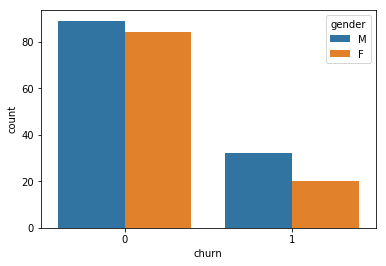

In [21]:
df2 = df_clean.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x="churn", y='count', hue="gender", data=df2)

男性用户比女性用户删除账户的人数更多

#### 3.用户付费之间和注销用户的关系

In [22]:
df_clean.dropDuplicates(["userId"]).groupby(["churn", "level"]).count().sort("level").show()


+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    0| free|  133|
|    1| free|   44|
|    0| paid|   40|
|    1| paid|    8|
+-----+-----+-----+



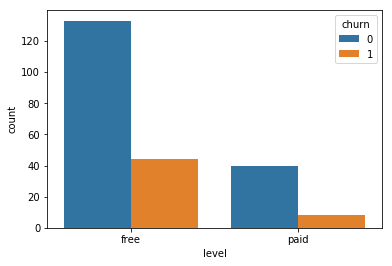

In [23]:
df3 = df_clean.dropDuplicates(["userId"]).groupby(["churn", "level"]).count().sort("level").toPandas()
sns.barplot(x="level", y='count', hue="churn", data=df3)

免费用户中，注销用户的人数比较多，付费用户的流失用户量比较少

#### 4. 查看取消收费订阅和免费订阅的数量


In [24]:
print(df_clean.filter((df_clean.churn == 1) & (df.level=='paid')).count())

print(df_clean.filter((df_clean.churn == 1) & (df.level=='free')).count())

32476
12388


#### 5.所在州之间的注销用户和留存用户之间的关系

In [25]:
df_clean.dropDuplicates(['userId', 'State']).groupby(["churn", "State"]).count().sort("churn").show()

+-----+---------+-----+
|churn|    State|count|
+-----+---------+-----+
|    0|       WI|    1|
|    0|    TN-VA|    1|
|    0|    NC-SC|    6|
|    0|       MI|    2|
|    0|    GA-AL|    2|
|    0|       WV|    1|
|    0|       UT|    1|
|    0|    MD-WV|    1|
|    0|       PA|    3|
|    0|       FL|   11|
|    0|       WA|    2|
|    0|       NV|    3|
|    0|       NJ|    2|
|    0|       CT|    7|
|    0|       GA|    4|
|    0|       TX|   13|
|    0|       MT|    1|
|    0|       CO|    2|
|    0|    MO-KS|    1|
|    0| NY-NJ-PA|   10|
+-----+---------+-----+
only showing top 20 rows



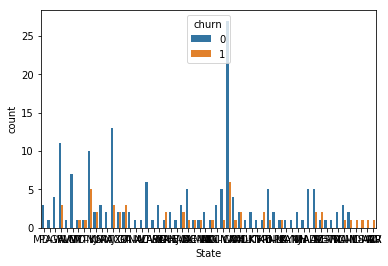

In [26]:
df5 = df_clean.dropDuplicates(['userId', 'State']).groupby(["churn", "State"]).count().sort("churn").toPandas()
sns.barplot(x="State", y='count', hue="churn", data=df5)
sns.set(rc={'figure.figsize':(50,20)})

从图表里可得知，CA这个州的客户流失量最大，其次是NY和FL这两个州

#### 6. 查看浏览页的分布情况

<Container object of 19 artists>

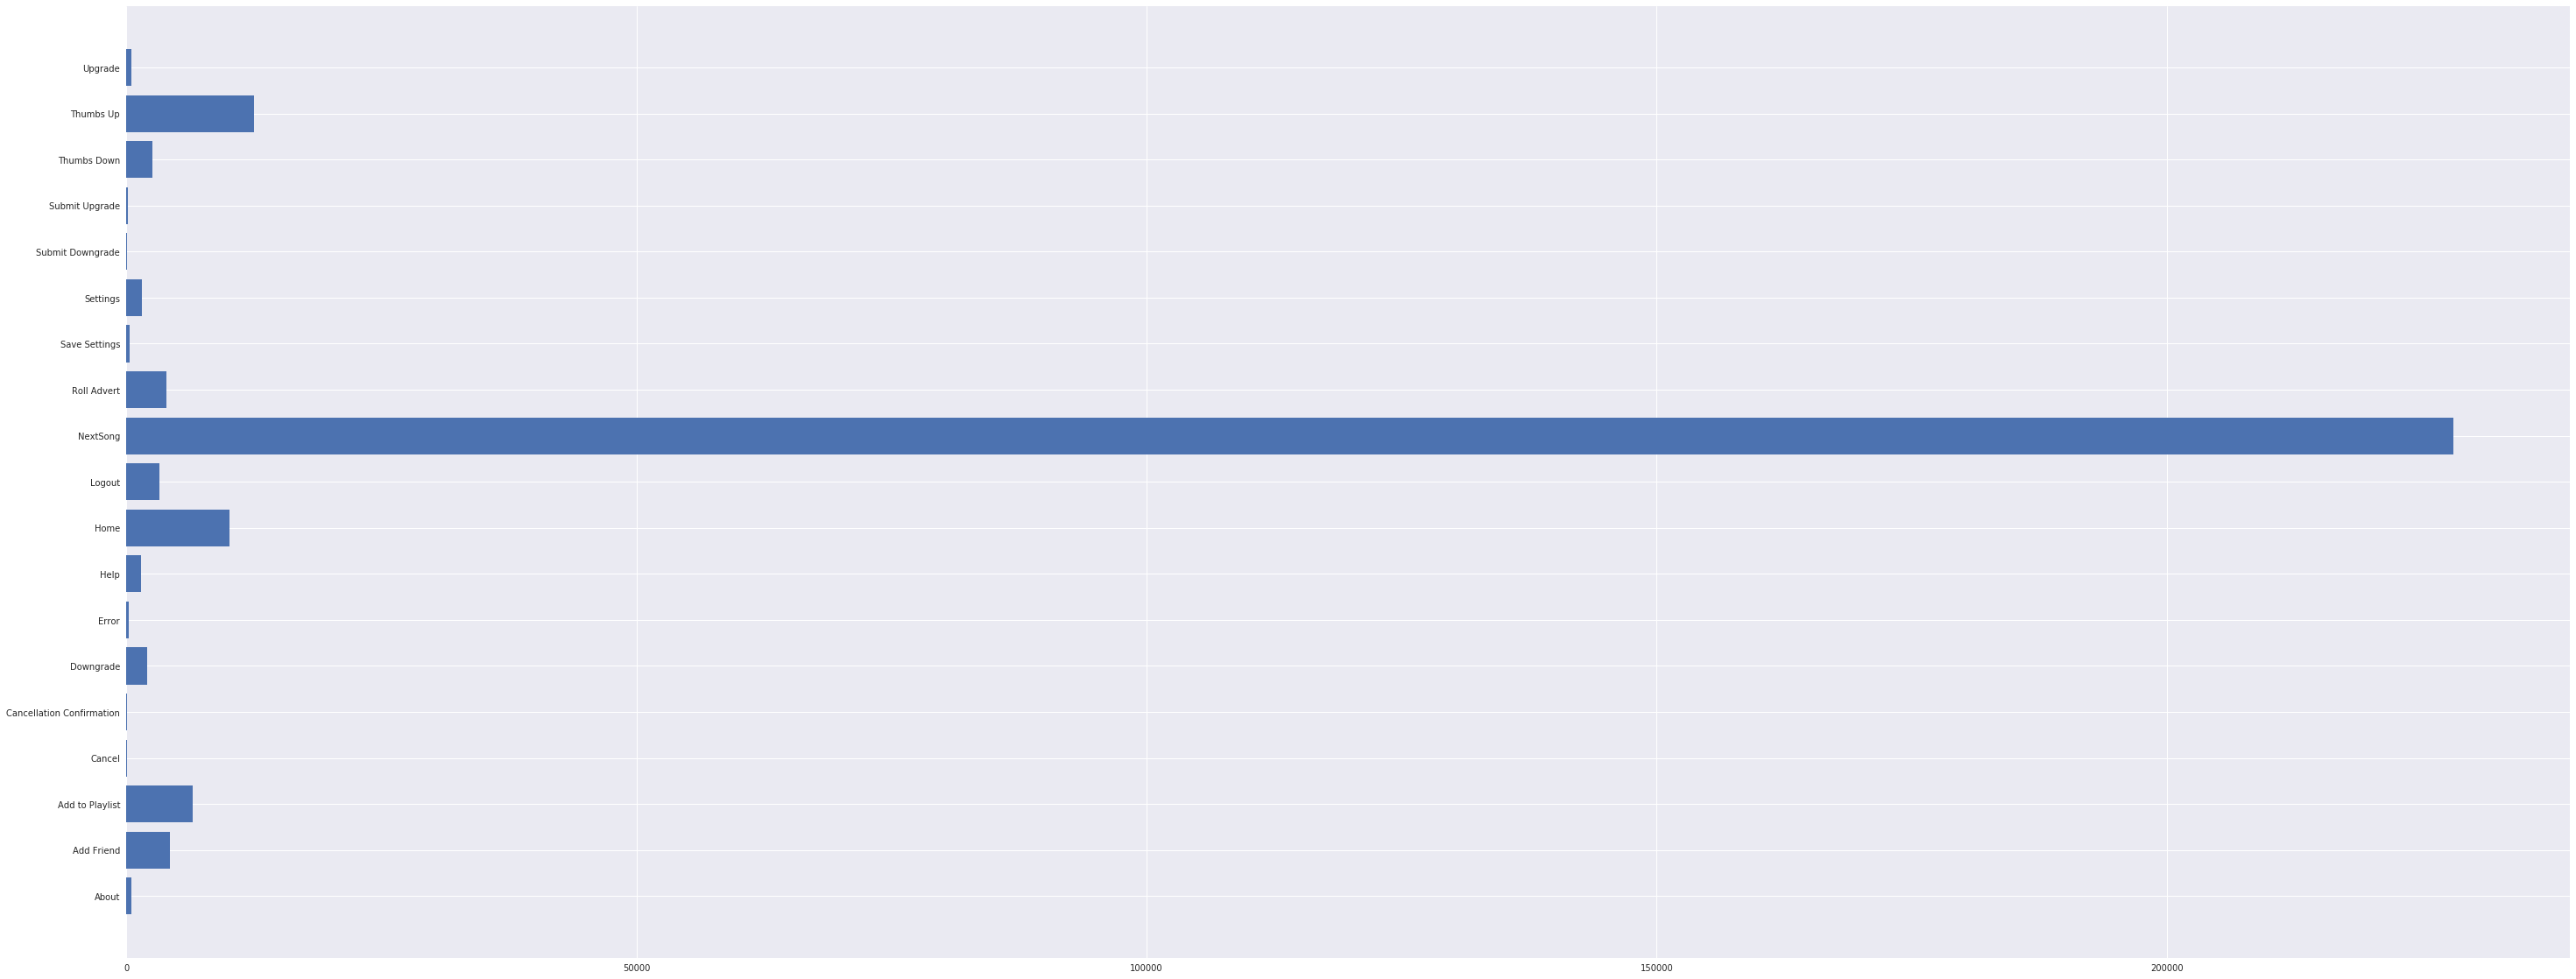

In [27]:
page_counts = df_clean.groupby("page").count().sort("count").toPandas()
page_counts['count'] = page_counts['count'].astype(float)

plt.barh(page_counts["page"], page_counts["count"])


绝大部分的用户选择‘NextSong’，其次是点赞或者将歌曲加入各单。从数据层面上可以发现，大部分用户还是对Spark是喜爱的。

# 特征工程


在大致的对数据进行分析后，决定保留或者综合数据内容得出如下相关元素：
 - 1.userId
 - 2.churn
 - 3.gender
 - 4.level
 - 5.ThumbsUp
 - 6.ThumbsDown
 - 7.AddtoPlaylist
 - 8.AddFriend
 - 9.songs
 - 10.artist

In [28]:
dfx.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- week_day: string (nullable = true)
 |-- time: string (nullable = true)



In [29]:
churn = dfx.filter(dfx.page=="Cancellation Confirmation").select("userId").dropDuplicates()

churn_list = [user["userId"] for user in churn.collect()]

churn_event = udf(lambda x:1 if x in churn_list else 0, IntegerType())

dfx = dfx.withColumn("churn", churn_event("userId"))

In [30]:
df_final = dfx.drop_duplicates(['userId']).select(['userId','churn','gender','level'])

In [31]:
df_final = df_final.replace(['F','M'], ['1', '0'],'gender')
df_final = df_final.replace(['paid','free'], ['1', '0'],'level')
df_final = df_final.withColumn('gender', df_final.gender.cast('int'))
df_final = df_final.withColumn('level', df_final.level.cast('int'))


In [32]:
songs = dfx.filter(dfx.song !='null').groupby('userId')\
.agg(count(dfx.song).alias('songs')).select(['userId','songs'])

artist = dfx.dropDuplicates(['userId','artist']).groupby('userId')\
.agg(count(dfx.artist).alias('artist')).select(['userId', 'artist'])

In [33]:
df_final = df_final.join(songs,'userId')
df_final = df_final.join(artist,'userId')

In [34]:
features = ['Thumbs Up','Thumbs Down','Add to Playlist','Add Friend' ]

for feature in features:
    feature_ = feature.replace(' ','')
    df_feature = dfx.filter(dfx.page==feature).groupby('userId')\
    .agg(count(dfx.page).alias(feature_)).select(['userId',feature_])
    
    df_final = df_final.join(df_feature,'userId')


In [35]:
df_final.show(5)

+------+-----+------+-----+-----+------+--------+----------+-------------+---------+
|userId|churn|gender|level|songs|artist|ThumbsUp|ThumbsDown|AddtoPlaylist|AddFriend|
+------+-----+------+-----+-----+------+--------+----------+-------------+---------+
|100010|    0|     1|    0|  275|   252|      17|         5|            7|        4|
|200002|    0|     0|    0|  387|   339|      21|         6|            8|        4|
|   124|    0|     1|    1| 4079|  2232|     171|        41|          118|       74|
|    51|    1|     0|    1| 2111|  1385|     100|        21|           52|       28|
|     7|    0|     0|    0|  150|   142|       7|         1|            5|        1|
+------+-----+------+-----+-----+------+--------+----------+-------------+---------+
only showing top 5 rows



In [52]:
df_final.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- songs: long (nullable = false)
 |-- artist: long (nullable = false)
 |-- ThumbsUp: long (nullable = false)
 |-- ThumbsDown: long (nullable = false)
 |-- AddtoPlaylist: long (nullable = false)
 |-- AddFriend: long (nullable = false)



In [53]:
data = df_final

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [80]:
#将数据集分成训练集、测试集和验证集
train, rest = df_final.randomSplit([0.7, 0.3], seed=42)
validation, test = rest.randomSplit([0.5,0.5], seed=42)

#### 一、逻辑回归

In [81]:
assembler = VectorAssembler(inputCols=df_final.columns[2:], outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features",withStd=True, withMean=True)
indexer = StringIndexer(inputCol='churn', outputCol='label')

In [82]:
lr =  LogisticRegression(maxIter=12, regParam=0.0, elasticNetParam=0)

In [83]:
# 建立管道
model_lr = Pipeline(stages=[assembler,scaler, indexer, lr])

# 建立参数网格
paramGrid = ParamGridBuilder().build()

# 设置交叉验证
crossval_lr = CrossValidator(estimator=model_lr,
                             estimatorParamMaps=paramGrid,
                             evaluator=MulticlassClassificationEvaluator(),
                            numFolds=3)



In [84]:
cvmodel_lr = crossval_lr.fit(train)
results_lr = cvmodel_lr.transform(validation)

In [85]:
evaluator  = MulticlassClassificationEvaluator(predictionCol="prediction" )

In [86]:
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.625
F-1 Score:0.4807692307692308


#### 二、随机森林

In [87]:
rf = RandomForestClassifier(numTrees=10)

# 建立管道
model_rf = Pipeline(stages=[assembler,scaler, indexer, rf])

# 建立参数网格
paramGrid = ParamGridBuilder().build()

# 设置交叉验证
crossval_rf = CrossValidator(estimator=model_rf,
                             estimatorParamMaps=paramGrid,
                             evaluator=MulticlassClassificationEvaluator(),
                            numFolds=3)





In [88]:
cvmodel_rf = crossval_rf.fit(train)
results_rf = cvmodel_rf.transform(validation)

In [89]:
evaluator  = MulticlassClassificationEvaluator(predictionCol="prediction" )

In [90]:
print('Random Forest Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))

Random Forest Metrics:
Accuracy: 0.5
F-1 Score:0.41666666666666663


#### 三、Gradient Boosted Trees 

In [91]:
gbt = GBTClassifier(maxIter=10,seed=42)

# 建立管道
model_gbt = Pipeline(stages=[assembler,scaler, indexer, gbt])

# 建立参数网格
paramGrid = ParamGridBuilder().build()

# 设置交叉验证
crossval_gbt = CrossValidator(estimator=model_gbt,
                             estimatorParamMaps=paramGrid,
                             evaluator=MulticlassClassificationEvaluator(),
                            numFolds=3)


In [92]:
cvmodel_gbt = crossval_gbt.fit(train)
results_gbt = cvmodel_gbt.transform(validation)

In [93]:
evaluator  = MulticlassClassificationEvaluator(predictionCol="prediction" )

In [94]:
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.375
F-1 Score:0.3409090909090909


### 结论：

根据三个模型对比后，发现逻辑回归的准确性和F1 score。因此采用这个模型可以更好的预测流失用户。处理大数据以改进模型时，其实我们也可以考虑添加更加多的指标。 比如滚动广告，注销用户的情况也可以添加到功能中

。